<a href="https://colab.research.google.com/github/kacperkurowski/CE888/blob/master/Assignment/Santander-Customer-Transaction-Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 1

In [0]:
import os
import seaborn as sns

In [0]:
os.environ['KAGGLE_USERNAME'] = "kacperkurowski" # username from the json file

os.environ['KAGGLE_KEY'] = "7c927dd985620db03df77b3804e71a95" # key from the json file

##1.Loading Data

In [9]:
!kaggle competitions download -c santander-customer-transaction-prediction # api copied from kaggle

 90% 112M/125M [00:01<00:00, 61.7MB/s] 
100% 125M/125M [00:01<00:00, 71.8MB/s]
  0% 0.00/462k [00:00<?, ?B/s]
100% 462k/462k [00:00<00:00, 144MB/s]
 86% 107M/125M [00:01<00:00, 71.4MB/s] 
100% 125M/125M [00:01<00:00, 95.8MB/s]


##1.Renaming Files as data downloaded causes overwrite due to same file names

In [10]:
!rename 's/test.csv.zip/test2.csv.zip/' test.csv.zip
!rename 's/train.csv.zip/train2.csv.zip/' train.csv.zip
!ls

sample_data  sample_submission.csv.zip	test2.csv.zip  train2.csv.zip


##1.Removing Files that are not used

In [11]:
!rm sample_submission.csv.zip
!ls

sample_data  test2.csv.zip  train2.csv.zip


##Loading the files

In [12]:
import pandas as pd

df_test2 = pd.read_csv("test2.csv.zip", compression = 'zip', header = 0, sep = ',', quotechar = '"')

print(df_test2)

df_train2 = pd.read_csv("train2.csv.zip", compression = 'zip', header = 0, sep = ',', quotechar = '"')

print(df_train2)

            ID_code    var_0    var_1  ...  var_197  var_198  var_199
0            test_0  11.0656   7.7798  ...  10.7200  15.4722  -8.7197
1            test_1   8.5304   1.2543  ...   9.8714  19.1293 -20.9760
2            test_2   5.4827 -10.3581  ...   7.0618  19.8956 -23.1794
3            test_3   8.5374  -1.3222  ...   9.2295  13.0168  -4.2108
4            test_4  11.7058  -0.1327  ...   7.2882  13.9260  -9.1846
...             ...      ...      ...  ...      ...      ...      ...
199995  test_199995  13.1678   1.0136  ...   9.1568  18.2102   4.8801
199996  test_199996   9.7171  -9.1462  ...   9.1112  18.1740 -20.7689
199997  test_199997  11.6360   2.2769  ...   9.1933  11.7905 -22.2762
199998  test_199998  13.5745  -0.5134  ...   8.1079   8.7735  -0.2122
199999  test_199999  10.4664   1.8070  ...  10.3378  14.3340  -7.7094

[200000 rows x 201 columns]
             ID_code  target    var_0  ...  var_197  var_198  var_199
0            train_0       0   8.9255  ...   8.5635  12.7803 

##Plotting Histogram of Santander-Customer-Transaction-Prediction Train Data

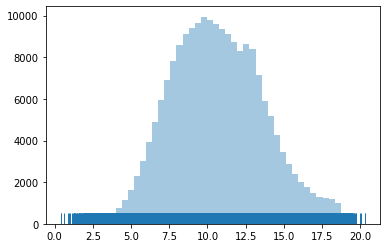

In [13]:
y_df = df_train2["var_0"].copy()
y = y_df.values
sns_plot = sns.distplot(y, kde=False, rug=True)

##Plotting Histogram of Santander-Customer-Transaction-Prediction Test Data

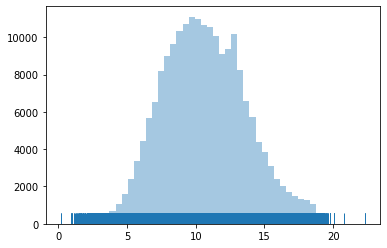

In [14]:
y_df = df_test2["var_0"].copy()
y = y_df.values
sns_plot = sns.distplot(y, kde=False, rug=True)

##Adding Test Columns for testing Covariate Shift

In [15]:
df_train2.drop(columns=['ID_code', 'target'], inplace=True)
df_test2.drop(columns=['ID_code'], inplace=True)
df_train2['is_test'] = 0
df_test2['is_test'] = 1
print(df_train2.head())
print(df_test2.head())

     var_0   var_1    var_2   var_3  ...  var_197  var_198  var_199  is_test
0   8.9255 -6.7863  11.9081  5.0930  ...   8.5635  12.7803  -1.0914        0
1  11.5006 -4.1473  13.8588  5.3890  ...   8.7889  18.3560   1.9518        0
2   8.6093 -2.7457  12.0805  7.8928  ...   8.2675  14.7222   0.3965        0
3  11.0604 -2.1518   8.9522  7.1957  ...  10.2922  17.9697  -8.9996        0
4   9.8369 -1.4834  12.8746  6.6375  ...   9.5031  17.9974  -8.8104        0

[5 rows x 201 columns]
     var_0    var_1    var_2   var_3  ...  var_197  var_198  var_199  is_test
0  11.0656   7.7798  12.9536  9.4292  ...  10.7200  15.4722  -8.7197        1
1   8.5304   1.2543  11.3047  5.1858  ...   9.8714  19.1293 -20.9760        1
2   5.4827 -10.3581  10.1407  7.0479  ...   7.0618  19.8956 -23.1794        1
3   8.5374  -1.3222  12.0220  6.5749  ...   9.2295  13.0168  -4.2108        1
4  11.7058  -0.1327  14.1295  7.7506  ...   7.2882  13.9260  -9.1846        1

[5 rows x 201 columns]


##Randomising Test and Train Data Sets

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

df = pd.concat([df_train2, df_test2], axis = 0)
X = df.drop(columns=['is_test'])
y = df['is_test']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
print('train2 shape:', X_train.shape, 'test2 shape:', X_test.shape)



##Let's use simple Random Forest as Classifier
#rfc = RandomForestClassifier()
#rfc.fit(X_train, y_train)
#y_test_score = rfc.predict_proba(X_test)



#import scikitplot as skplt
#import matplotlib.pyplot as plt

#skplt.metrics.plot_roc_curve(y_test, y_test_score)
#plt.show()


##AUC score is about 0.5
#print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))

train2 shape: (280000, 200) test2 shape: (120000, 200)


In [17]:
pip install scikit-plot

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


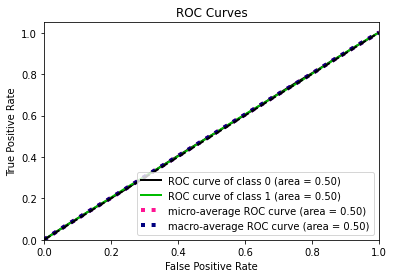

AUC score:  0.5037


In [18]:
##Let's use simple Random Forest as Classifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_test_score = rfc.predict_proba(X_test)

import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc_curve(y_test, y_test_score)
plt.show()


##AUC score is about 0.5
print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))